### Sematic Chunking 

In [53]:
with open('./mit.txt') as file:
    essay = file.read()

In [54]:
# Split the essay into words
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', essay)
print (f"{len(single_sentences_list)} senteneces were found")

110 senteneces were found


In [55]:
# Convert into list of dict with sentence and index
sentences: list[dict] = [{'sentence': sentence, 'index': index} for index, sentence in enumerate(single_sentences_list)]
print(len(sentences))
sentences[:3]

110


[{'sentence': 'Sun*\n\nKHÁM PHÁ VÙNG ĐẤT MẶT TRỜI\n\nHANDBOOK\n\nMake awesome things that matter.',
  'index': 0},
 {'sentence': '**Thư Ngỏ**\n\nChào mừng bạn gia nhập đại gia đình Sun Asterisk.',
  'index': 1},
 {'sentence': 'Sun* thật may mắn khi trở thành nơi làm việc của những con người có cùng đam mê và chí hướng.',
  'index': 2}]

In [56]:
# Create buffer_size
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [57]:
sentences[:3]

[{'sentence': 'Sun*\n\nKHÁM PHÁ VÙNG ĐẤT MẶT TRỜI\n\nHANDBOOK\n\nMake awesome things that matter.',
  'index': 0,
  'combined_sentence': 'Sun*\n\nKHÁM PHÁ VÙNG ĐẤT MẶT TRỜI\n\nHANDBOOK\n\nMake awesome things that matter. **Thư Ngỏ**\n\nChào mừng bạn gia nhập đại gia đình Sun Asterisk.'},
 {'sentence': '**Thư Ngỏ**\n\nChào mừng bạn gia nhập đại gia đình Sun Asterisk.',
  'index': 1,
  'combined_sentence': 'Sun*\n\nKHÁM PHÁ VÙNG ĐẤT MẶT TRỜI\n\nHANDBOOK\n\nMake awesome things that matter. **Thư Ngỏ**\n\nChào mừng bạn gia nhập đại gia đình Sun Asterisk. Sun* thật may mắn khi trở thành nơi làm việc của những con người có cùng đam mê và chí hướng.'},
 {'sentence': 'Sun* thật may mắn khi trở thành nơi làm việc của những con người có cùng đam mê và chí hướng.',
  'index': 2,
  'combined_sentence': '**Thư Ngỏ**\n\nChào mừng bạn gia nhập đại gia đình Sun Asterisk. Sun* thật may mắn khi trở thành nơi làm việc của những con người có cùng đam mê và chí hướng. Với sự kiên định và quyết tâm trên con

In [58]:
!pip install langchain
!pip install -U langchain-community
!pip install openai
!pip install tiktoken

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [59]:
from langchain.embeddings import OpenAIEmbeddings
oaiembeds = OpenAIEmbeddings(openai_api_key="""")

In [60]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

In [61]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [62]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [63]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [64]:
distances, sentences = calculate_cosine_distances(sentences)

In [65]:
distances[:3]

[0.010522198723164067, 0.061516709714558804, 0.0800509750035745]

In [66]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


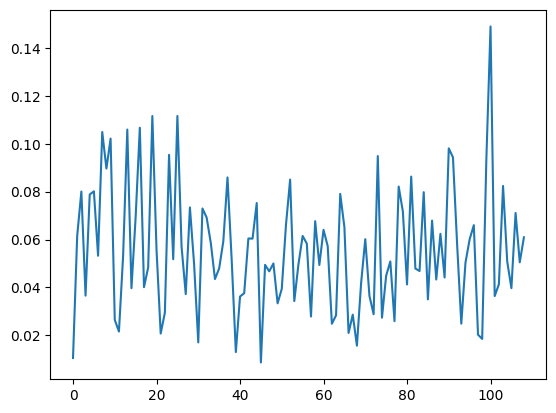

In [67]:
import matplotlib.pyplot as plt

plt.plot(distances);

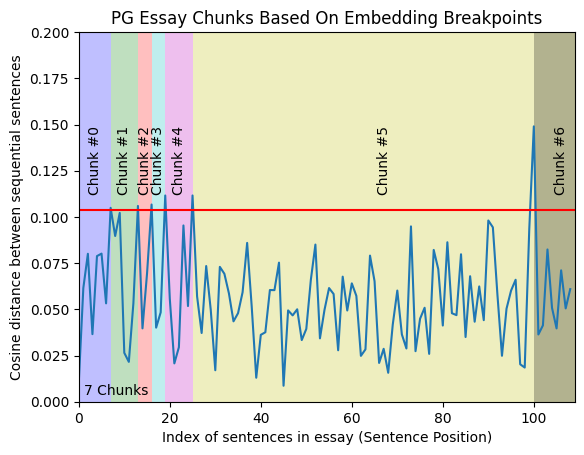

In [68]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [69]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [70]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
Sun*

KHÁM PHÁ VÙNG ĐẤT MẶT TRỜI

HANDBOOK

Make awesome things that matter. **Thư Ngỏ**

Chào mừng bạn gia nhập đại gia đình Sun Asterisk. Sun* thật may mắn khi trở thành nơi làm việc của những con n
...
sẽ kiến tạo những giá trị tuyệt vời cho thế giới tươi đẹp này. Sun Asterisk Inc. CEO
KOBAYASHI TAIHEI

HÀNH TRÌNH HAI THÁNG ĐẦU TIÊN

NGÀY ĐẦU TIÊN

1. Gặp gỡ Sun* Bear, khám phá Vùng đất Mặt trời

2.


Chunk #1
Hoàn thiện các giấy tờ, thủ tục "nhập gia"

3. Tiếp nhận và cài đặt thiết bị làm việc

4. Kết nối với người đồng hành (Mentor và UM*/ HRBP*)

5. Làm quen với đội nhóm, phòng ban và bắt đầu tiếp cận cô
...
gười quản lý dự án (ở từng tổ chức thường gọi là PM)

**Your Journey**
**Starts Here!**

---

"A, bạn đây rồi! Tôi là Sun* Bear*, hướng dẫn viên của bạn trong ngày đầu tiên khám phá Vùng đất Mặt Trời.




In [71]:
print(chunk[0])

H


In [72]:
# Clear

In [76]:
!pip install llama-index-embeddings-openai
!pip install llama-index-readers-file

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 KB 12.6 MB/s eta 0:00:00


In [77]:
from llama_index.core import SimpleDirectoryReader

# load documents
documents = SimpleDirectoryReader(input_files=["mit.txt"]).load_data()

In [78]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)
from llama_index.embeddings.openai import OpenAIEmbedding

import os

os.environ["OPENAI_API_KEY"] = """"

In [83]:
embed_model = OpenAIEmbedding()
splitter = SemanticSplitterNodeParser(
    buffer_size=1, breakpoint_percentile_threshold=95, embed_model=embed_model
)

# also baseline splitter
base_splitter = SentenceSplitter(chunk_size=1024)

In [84]:
nodes = splitter.get_nodes_from_documents(documents)

In [85]:
print(nodes[1].get_content())

Tôi là Sun* Bear*, hướng dẫn viên của bạn trong ngày đầu tiên khám phá Vùng đất Mặt Trời.
Lên xe làm một vòng nào bạn ơi!"

(*): Sun* Bear* là biệt hiệu của Sun*, đây là cảm hứng từ loài Gấu Mặt Trời với đặc tính vui vẻ, năng động, ưa thích leo trèo và cảnh giác cao với những gì xung quanh mình. Những đặc tính này đã dẫn đến việc tạo hình chú gấu Sun* Bear* với biểu tượng ngôi sao trên ngực và luôn sẵn sàng giúp đỡ mọi người.

**THEO DẤU HÀNH TRÌNH**

**Xem kia, biết bao nhiêu điều thú vị! 


In [86]:
print(nodes[2].get_content())

Let's go!**

Trong nỗ lực để đạt đến sứ mệnh của Sun*, việc tạo ra một môi trường - nơi tất cả các thành viên có thể phát huy điểm mạnh riêng là tối quan trọng. Vì thế, điều đầu tiên tôi mong tất cả lãnh đạo của Sun* đặc biệt lưu ý trong việc thiết lập mục tiêu của mình, đó là vấn đề động lực, sự an tâm về mặt tâm lý và sự phát triển của nhân viên.

CEO Taihei Kobayashi
Hào hứng chưa nào? 
